In [6]:
import chess.pgn
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set(style="white")
from collections import Counter
import networkx as nx
import plotly.express as px

In [2]:
## source: https://github.com/dsharpc/ChessNetworks/blob/master/data_parser/notebooks/Parser.ipynb
class Match:
    def __init__(self, game):
        self.game = game
        self.white = game.headers.get('White')
        self.black = game.headers.get('Black')
        self.game_id = game.headers.get('Site').split('/')[-1]
        self.moves = self.get_moves()
        self.tracker = game.board().piece_map()
        self.start_tracker()
        self.black_elo = game.headers.get('BlackElo')
        self.white_elo = game.headers.get('WhiteElo')
        self.opening = game.headers.get('Opening')
        self.eco = game.headers.get('ECO')
        self.termination = game.headers.get('Termination')
        self.date = game.headers.get('UTCDate')
        self.winner = self.get_winner(game.headers.get('Result'))
    
    @staticmethod
    def get_winner(results):
        results = results.split('-')
        if results[0] == '1':
            return 'White'
        if results[0] == '1/2':
            return 'Tie'
        else:
            return 'Black'
        
    @staticmethod 
    def castling_move_rook(from_square, to_square):
        if from_square == 4:
            if to_square == 6:
                return {'piece':7, 'move':(7,5)}
            elif to_square == 2:
                return {'piece':0, 'move':(0,3)}
        elif from_square == 60:
            if to_square == 62:
                return {'piece':63, 'move':(63,61)}
            elif to_square == 58:
                return {'piece':56, 'move':(56,59)}
    
    def get_moves(self):
        moves = []
        for move in self.game.mainline_moves():
            from_m = move.from_square
            to_m = move.to_square
            moves.append((from_m, to_m))
        return moves
    
    @staticmethod
    def _to_uci(square):
        square = int(square)
        letter = chr(ord('a') + ((square)%8)) 
        number = square//8+1
        return f"{letter}{number}"
    
    def start_tracker(self):
        for key in self.tracker.keys():
            self.tracker[key] = {'piece': self.tracker[key].unicode_symbol()+'-'+str(self._to_uci(key)),\
                                 'moves':[], 'last_square':key,'captured':False, 'captures':[], 'move_nums':[]}
        
    def fill_tracker(self):
        for idx,mov in enumerate(self.moves):
            from_m, to_m = mov
            piece = [key for (key,value) in self.tracker.items() if value.get('last_square') == from_m and value.get('captured') is False][0]
            captured = [key for (key,value) in self.tracker.items() if value.get('last_square') == to_m and value.get('captured') is False]
            if len(captured) > 0:
                captured = captured[0]
                self.tracker[captured]['captured'] = True
                self.tracker[piece]['captures'].append(self.tracker[captured].get('piece'))
            self.tracker[piece]['moves'].append(to_m)
            if piece in [4,60] and abs(from_m - to_m) == 2:
                castled = self.castling_move_rook(from_m,to_m)
                self.tracker[castled['piece']]['moves'].append(castled['move'][1])
                self.tracker[castled['piece']]['last_square'] = castled['move'][1]
            self.tracker[piece]['last_square'] = to_m
            self.tracker[piece]['move_nums'].append(idx)
            
    def get_mean_elo(self):
        try:
            mean = (int(self.black_elo) + int(self.white_elo))/2
            return mean
        except:
            return np.nan
        
    def get_dataframe(self):
        df = pd.DataFrame.from_dict(self.tracker, orient='index')
        df['game_id'] = self.game_id
        df['mean_elo'] = self.get_mean_elo()
        
        return df

In [3]:
games = {}
limit = 500 # for testing
with open('data/lichess_db_standard_rated_2013-02.pgn', 'r') as pgn_file:
    game = chess.pgn.read_game(pgn_file)
    L = 0
    while game != None:
        match = Match(game)
        idx = match.game_id
        games[idx] = match
        game = chess.pgn.read_game(pgn_file)
        L += 1
        if L == limit: break

In [4]:
for game in games.values():
    game.fill_tracker()
data = pd.concat([i.get_dataframe() for i in games.values()])

In [5]:
data

,piece,moves,last_square,captured,captures,move_nums,game_id,mean_elo
63,♜-h8,[62],62,False,[],[29],9tp6v4ps,1339.5
62,♞-g8,[45],45,True,[],[11],9tp6v4ps,1339.5
61,♝-f8,[],61,False,[],[],9tp6v4ps,1339.5
60,♚-e8,[],60,False,[],[],9tp6v4ps,1339.5
59,♛-d8,"[43, 35, 36, 9]",9,True,"[♘-b1, ♙-b2]","[7, 23, 25, 27]",9tp6v4ps,1339.5
...,...,...,...,...,...,...,...,...
4,♔-e1,"[6, 13, 22, 30, 29, 37, 36, 43, 34, 33, 32, 40...",57,False,"[♟-d7, ♟-c7, ♟-a7]","[8, 68, 82, 90, 92, 96, 100, 104, 106, 108, 11...",kbbwn4v9,1597.5
3,♕-d1,"[5, 13, 45, 31]",31,True,[♟-g7],"[42, 44, 48, 62]",kbbwn4v9,1597.5
2,♗-c1,[20],20,True,[],[22],kbbwn4v9,1597.5
1,♘-b1,"[11, 21, 11, 21, 36]",36,True,[♜-h8],"[24, 36, 38, 50, 52]",kbbwn4v9,1597.5


In [7]:
data.sort_values(by='mean_elo')

,piece,moves,last_square,captured,captures,move_nums,game_id,mean_elo
63,♜-h8,[],63,False,[],[],hcrm1twx,1198.5
0,♖-a1,[],0,False,[],[],hcrm1twx,1198.5
1,♘-b1,"[11, 5]",5,False,[],"[14, 28]",hcrm1twx,1198.5
2,♗-c1,[],2,False,[],[],hcrm1twx,1198.5
3,♕-d1,"[19, 17, 24, 32, 34, 48]",48,False,"[♝-f8, ♟-b7, ♟-a7]","[12, 16, 22, 24, 32, 34]",hcrm1twx,1198.5
...,...,...,...,...,...,...,...,...
4,♔-e1,"[3, 10, 17]",17,False,[],"[26, 42, 46]",oiq70mvu,NaN
3,♕-d1,[11],11,True,[],[24],oiq70mvu,NaN
2,♗-c1,[],2,True,[],[],oiq70mvu,NaN
1,♘-b1,[16],16,True,[],[20],oiq70mvu,NaN


In [8]:
def first_winning_moves(games):
    first_moves = {'White':Counter(), 'Black':Counter()}
    for idx,match in games.items():
        winner = match.winner
        if winner == 'Tie': continue
        white = match.get_moves()[0]
        black = match.get_moves()[1]
        first_moves[winner].update([white if winner == 'White' else black])
    return first_moves

In [9]:
x = first_winning_moves(games)

In [10]:
def first_moves(games):
    first_moves = {'White':Counter(), 'Black':Counter()}
    for idx,match in games.items():
        white = match.get_moves()[0]
        black = match.get_moves()[1]
        first_moves['White'].update([white])
        first_moves['Black'].update([black])
    return first_moves

In [11]:
y = first_moves(games)

In [12]:
for color,counter in x.items():
    print(f'{color} - {counter.most_common()}')
    print(f'{color} - {y[color].most_common()}')

White - [((12, 28), 151), ((11, 27), 71), ((6, 21), 16), ((11, 19), 8), ((13, 29), 7), ((10, 26), 5), ((12, 20), 3), ((9, 17), 3), ((10, 18), 3), ((14, 22), 1)]
White - [((12, 28), 269), ((11, 27), 134), ((6, 21), 29), ((10, 26), 17), ((11, 19), 13), ((13, 29), 11), ((9, 17), 6), ((10, 18), 6), ((12, 20), 5), ((14, 22), 4), ((9, 25), 3), ((14, 30), 1), ((1, 18), 1), ((8, 16), 1)]
Black - [((52, 36), 77), ((51, 35), 57), ((62, 45), 22), ((50, 34), 21), ((52, 44), 12), ((49, 41), 9), ((51, 43), 8), ((54, 46), 6), ((57, 42), 3), ((50, 42), 3), ((53, 37), 2), ((49, 33), 1)]
Black - [((52, 36), 172), ((51, 35), 116), ((50, 34), 50), ((62, 45), 45), ((52, 44), 37), ((51, 43), 17), ((54, 46), 16), ((49, 41), 16), ((50, 42), 12), ((57, 42), 11), ((53, 37), 4), ((48, 32), 1), ((48, 40), 1), ((62, 47), 1), ((49, 33), 1)]


In [13]:
def move_win_rate_per_move(winners,moves):
    white_win_rates = {}
    black_win_rates = {}
    for i in moves['White'].keys():
        if i in winners['White']:
            white_win_rates[i] = winners['White'][i]/moves['White'][i]
        else:
            white_win_rates[i] = 0
    for i in moves['Black'].keys():
        if i in winners['Black']:
            black_win_rates[i] = winners['Black'][i]/moves['Black'][i]
        else:
            black_win_rates[i] = 0
    return white_win_rates,black_win_rates

In [14]:
move_win_rate_per_move(x,y)

({(12, 28): 0.5613382899628253,
  (11, 19): 0.6153846153846154,
  (11, 27): 0.5298507462686567,
  (9, 17): 0.5,
  (14, 30): 0,
  (10, 26): 0.29411764705882354,
  (9, 25): 0,
  (6, 21): 0.5517241379310345,
  (1, 18): 0,
  (12, 20): 0.6,
  (13, 29): 0.6363636363636364,
  (14, 22): 0.25,
  (10, 18): 0.5,
  (8, 16): 0},
 {(51, 35): 0.49137931034482757,
  (52, 36): 0.4476744186046512,
  (50, 34): 0.42,
  (62, 45): 0.4888888888888889,
  (52, 44): 0.32432432432432434,
  (54, 46): 0.375,
  (51, 43): 0.47058823529411764,
  (50, 42): 0.25,
  (49, 41): 0.5625,
  (57, 42): 0.2727272727272727,
  (53, 37): 0.5,
  (48, 32): 0,
  (48, 40): 0,
  (62, 47): 0,
  (49, 33): 1.0})

In [15]:
def to_uci(square):
        square = int(square)
        letter = chr(ord('a') + ((square)%8)) 
        number = square//8+1
        return f"{letter}{number}"

In [16]:
def move_win_rate(winners,moves):
    white_win_rates = {}
    black_win_rates = {}
    white_wins = sum(winners['White'].values())
    white_moves = sum(moves['White'].values())
    black_wins = sum(winners['Black'].values())
    black_moves = sum(moves['Black'].values())
    for i in moves['White'].keys():
        legible_i = (to_uci(i[0]), to_uci(i[1]))
        if i in winners['White']:
            white_win_rates[legible_i] = (round(winners['White'][i]/moves['White'][i], 3), round(moves['White'][i]/white_moves, 3))
        else:
            white_win_rates[legible_i] = (0, round(moves['White'][i]/white_moves, 3))
    for i in moves['Black'].keys():
        legible_i = (to_uci(i[0]), to_uci(i[1]))
        if i in winners['Black']:
            black_win_rates[legible_i] = (round(winners['Black'][i]/moves['Black'][i], 3), round(moves['Black'][i]/black_moves, 3))
        else:
            black_win_rates[legible_i] = (0, round(moves['Black'][i]/black_moves, 3))
    return white_win_rates,black_win_rates

In [17]:
move_win_rate(x,y)

({('e2', 'e4'): (0.561, 0.538),
  ('d2', 'd3'): (0.615, 0.026),
  ('d2', 'd4'): (0.53, 0.268),
  ('b2', 'b3'): (0.5, 0.012),
  ('g2', 'g4'): (0, 0.002),
  ('c2', 'c4'): (0.294, 0.034),
  ('b2', 'b4'): (0, 0.006),
  ('g1', 'f3'): (0.552, 0.058),
  ('b1', 'c3'): (0, 0.002),
  ('e2', 'e3'): (0.6, 0.01),
  ('f2', 'f4'): (0.636, 0.022),
  ('g2', 'g3'): (0.25, 0.008),
  ('c2', 'c3'): (0.5, 0.012),
  ('a2', 'a3'): (0, 0.002)},
 {('d7', 'd5'): (0.491, 0.232),
  ('e7', 'e5'): (0.448, 0.344),
  ('c7', 'c5'): (0.42, 0.1),
  ('g8', 'f6'): (0.489, 0.09),
  ('e7', 'e6'): (0.324, 0.074),
  ('g7', 'g6'): (0.375, 0.032),
  ('d7', 'd6'): (0.471, 0.034),
  ('c7', 'c6'): (0.25, 0.024),
  ('b7', 'b6'): (0.562, 0.032),
  ('b8', 'c6'): (0.273, 0.022),
  ('f7', 'f5'): (0.5, 0.008),
  ('a7', 'a5'): (0, 0.002),
  ('a7', 'a6'): (0, 0.002),
  ('g8', 'h6'): (0, 0.002),
  ('b7', 'b5'): (1.0, 0.002)})

In [18]:
terminations = Counter()
for key,value in games.items():
    terminations[value.termination] += 1
terminations

Counter({'Time forfeit': 173, 'Normal': 327})

In [19]:
capture_graph = nx.DiGraph()

In [20]:
captures = data['piece'].unique()

In [21]:
captures = pd.DataFrame(captures)

In [22]:
captures[0][0]

'♜-h8'

In [23]:
tmp = []

In [24]:
for i in data[data['piece'] == '♜-h8']['captures']:
    if not i:
        continue
    tmp.extend(i)

In [25]:
capture_graph.add_nodes_from(captures[0])

In [26]:
capture_graph.add_edges_from([('♜-h8',i, {'weight':tmp.count(i)}) for i in tmp])

In [27]:
capture_graph.edges

OutEdgeView([('♜-h8', '♖-a1'), ('♜-h8', '♙-a2'), ('♜-h8', '♙-g2'), ('♜-h8', '♙-h2'), ('♜-h8', '♖-h1'), ('♜-h8', '♘-b1'), ('♜-h8', '♙-e2'), ('♜-h8', '♙-c2'), ('♜-h8', '♗-c1'), ('♜-h8', '♕-d1'), ('♜-h8', '♘-g1'), ('♜-h8', '♙-b2'), ('♜-h8', '♙-d2'), ('♜-h8', '♗-f1'), ('♜-h8', '♙-f2')])

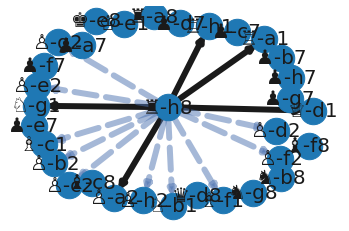

In [28]:
elarge=[(u,v) for (u,v,d) in capture_graph.edges(data=True) if d['weight'] >15]
esmall=[(u,v) for (u,v,d) in capture_graph.edges(data=True) if d['weight'] <=15]
pos = nx.spring_layout(capture_graph)
nx.draw_networkx_nodes(capture_graph,pos,node_size=700)
nx.draw_networkx_edges(capture_graph, pos, edgelist=elarge, width=6)
nx.draw_networkx_edges(capture_graph,pos,edgelist=esmall,width=6,alpha=0.5,edge_color='b',style='dashed')
nx.draw_networkx_labels(capture_graph,pos,font_size=20,font_family='sans-serif')
plt.axis('off')
plt.show()

In [89]:
captures_df = (data.explode('captures').groupby(['piece','captures'])['game_id'].nunique()).to_frame().reset_index().sort_values('game_id', ascending=False).assign(piece_type = lambda df: df['piece'].str.split('-').str.get(0))

In [90]:
captures_df.to_csv('captures_df.csv')

In [70]:
px.bar(captures_df, x='piece', y='game_id', color='captures').write_html('captures_white.html')

In [91]:
captures_df

,piece,captures,game_id,piece_type
15,♕-d1,♛-d8,113,♕
230,♛-d8,♕-d1,98,♛
294,♝-f8,♗-c1,87,♝
63,♗-c1,♝-f8,85,♗
173,♙-e2,♟-d7,84,♙
...,...,...,...,...
404,♟-f7,♙-c2,1,♟
191,♙-g2,♛-d8,1,♙
357,♟-b7,♙-g2,1,♟
165,♙-e2,♜-a8,1,♙


In [92]:
captures_df['color'] = captures_df['piece_type'].apply(lambda x: 'white' if ord(x) >= 9812 or ord(x) <= 9817 else 'black')

In [97]:
captures_df['captured_piece_type'] = captures_df['captures'].apply(lambda x: x[0])

In [98]:
captures_df

,piece,captures,game_id,piece_type,color,captured_piece_type
15,♕-d1,♛-d8,113,♕,white,♛
230,♛-d8,♕-d1,98,♛,white,♕
294,♝-f8,♗-c1,87,♝,white,♗
63,♗-c1,♝-f8,85,♗,white,♝
173,♙-e2,♟-d7,84,♙,white,♟
...,...,...,...,...,...,...
404,♟-f7,♙-c2,1,♟,white,♙
191,♙-g2,♛-d8,1,♙,white,♛
357,♟-b7,♙-g2,1,♟,white,♙
165,♙-e2,♜-a8,1,♙,white,♜


In [104]:
new_df = pd.DataFrame()
new_df['piece'] = captures_df['piece_type'].unique()
new_df['captured_piece'] = captures_df['captured_piece_type'].unique()
new_df['capture_count'] = new_df.apply(lambda x: sum(captures_df[(captures_df['piece_type'] == x['piece']) & (captures_df['captured_piece_type'] == x['captured_piece'])]['game_id']), axis=1)

ValueError: Length of values (10) does not match length of index (12)

In [94]:
captures_df.to_csv('captures_df.csv')

In [102]:
sum(captures_df[(captures_df['piece_type'] == '♙') & (captures_df['captured_piece_type'] == '♟')]['game_id'])

684

In [109]:
new_df = captures_df[['piece_type', 'captured_piece_type']].drop_duplicates()

In [110]:
new_df

,piece_type,captured_piece_type
15,♕,♛
230,♛,♕
294,♝,♗
63,♗,♝
173,♙,♟
...,...,...
128,♙,♛
245,♛,♟
103,♘,♙
410,♟,♟


In [112]:
new_df['capture_count'] = new_df.apply(lambda x: sum(captures_df[(captures_df['piece_type'] == x['piece_type']) & (captures_df['captured_piece_type'] == x['captured_piece_type'])]['game_id']), axis=1)

In [113]:
new_df

,piece_type,captured_piece_type,capture_count
15,♕,♛,113
230,♛,♕,98
294,♝,♗,170
63,♗,♝,166
173,♙,♟,684
...,...,...,...
128,♙,♛,20
245,♛,♟,2
103,♘,♙,1
410,♟,♟,1
